`ypp` (_pronounced Yippee!) helps manager your interactive state. `ypp.Output` objects are evented `traitlets` or `ipywidgets`
that update as the interative state of an `IPython.InteractiveShell` is changed.  `ypp.Handler` objects are evented to change
within special `globals` and `locals` namepsaces.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/deathbeds/ypp/e3a3868bf9eb9d051114540d86a8e5e94e78ae81?filepath=examples.ipynb)

In [1]:
    import contextlib , sys, IPython, traitlets, contextlib, functools, itertools, inspect, collections

    try: import ipywidgets
    except: ipywidgets = None
    try: import hypothesis
    except: hypothesis = None
        
    if __name__ == '__main__': 
        get_ipython = IPython.get_ipython
        %reload_ext ypp
        from jason import *
        get_ipython().run_line_magic("reload_ext", "pidgin")


In [2]:
    class Output(traitlets.HasTraits):
`Output` is the base class for the ypp interactive TraitletOutputWidgetOutput.
>>> Output()
<...Output...>

        value = traitlets.Any()
        description = traitlets.Unicode()

In [3]:
    class TraitletOutput(IPython.display.DisplayHandle, Output):
`TraitletOutput` is a non-`ipywidgets` interactive `Output` thats updates using the builtin
`IPython.display.DisplayHandle` system.
        
        def _ipython_display_(TraitletOutput, before=None, after=None):
`TraitletOutput._ipython_display_` displays the `TraitletOutput.description` if it exists 
and then displays the `TraitletOutput.value`.  `TraitletOutput` manages updating existing display objects.
            
            if TraitletOutput.description:
                IPython.display.display(IPython.display.Markdown('#### ' + TraitletOutput.description))
            TraitletOutput.display(TraitletOutput.value)

    
        @traitlets.observe('value')
        def _change_value(TraitletOutput, change): 
When `TraitletOutput.value` changes `TraitletOutput._change_value` triggers the `IPython.display.DisplayHandle` to __update__.
            
            TraitletOutput.update(change['new'])

        stack = traitlets.List()        
        def __enter__(TraitletOutput):
`TraitletOutput.__enter__` changes the context of how display objects are published using `IPython.utils.capture`.
            
            object = IPython.utils.capture.capture_output()  
We use a stack just in case...

            TraitletOutput.stack.append((object, object.__enter__()))
            
        def __exit__(TraitletOutput, *e):
`TraitletOutput.__exit__` the `TraitletOutput.stack` and `TraitletOutput.update` any existing displays.

            capturer, captured = TraitletOutput.stack.pop()
            capturer.__exit__(*e)
            outputs = captured.outputs and captured.outputs[0].data or {'text/plain': captured.stdout}
            TraitletOutput.update(outputs, raw=True)
        
        def __init__(TraitletOutput, *args, **kwargs):
            IPython.display.DisplayHandle.__init__(TraitletOutput)
            Output.__init__(TraitletOutput, *args, **kwargs)

In [4]:
    class ListOutput(TraitletOutput):
        def _ipython_display_(ListOutput, before=None, after=None):
            if ListOutput.description:
                IPython.display.display(IPython.display.Markdown('#### ' + ListOutput.description))
            IPython.display.display(*ListOutput.value)


In [5]:
    @contextlib.contextmanager
    def pandas_ambiguity(nz=None):
        pandas = sys.modules.get('pandas', None)
        if pandas:
            pandas.Series.__bool__ = pandas.DataFrame.__bool__ = lambda df: True
            yield
            try: del pandas.DataFrame.__bool__, pandas.Series.__bool__
            except: ...
        else: yield

In [6]:
    class Handler(traitlets.HasTraits):
`Handler` is a `traitlets` `object` that manager state between itself and the `Handler.parent`.
>>> handler = Handler(foo=2)
>>> handler
<...Handler...>

        parent = traitlets.Instance(IPython.InteractiveShell, help=
`Handler.parent` is a shell who's namespace is evented with the `Handler`.
>>> handler.parent
<...Shell...>
            
                                   )
        children = traitlets.Tuple(help=
`Handler.children` holds the widgets for the `Handler`
                                  
                                  )
        display = traitlets.Dict(help=
`Handler.display` is a keyed version of the `Handler.children`.
>>> assert handler.children == tuple(handler.display.values())
                                 
                                )
        wait = traitlets.Bool(False)
        display_cls = traitlets.Type(TraitletOutput, help=
>>> # assert issubclass(handler.display_cls, Output)
                                    
                                    )
        

        callable = traitlets.Any()        
        globals = traitlets.Any()
        locals = traitlets.Any()
        container = traitlets.Any()
        annotations = traitlets.Any()
>>> h = Handler('y')
>>> h.locals
ChainMap({}, {})


                
        def default_container(App):
            return ListOutput(value=list(App.children))

        def globalize(App, parent, globals, locals):
            globs = collections.ChainMap()
            for glob in globals: 
                if glob not in locals or glob: 
                    for key in glob.split():
                        globs[key] = parent.user_ns.get(key, None)
            return globs

        def __init__(App, *globals, wait=False, parent=None, **locals):
            parent = parent or IPython.get_ipython()
            super().__init__(parent=parent, wait=wait, locals=collections.ChainMap(locals), globals=App.globalize(parent, globals, locals), callable=locals.pop('callable', None), annotations=collections.ChainMap())
            App.annotate()
            App.localize()
            App.add_traits()
            App.container = App.default_container()
            App.link()
            

        
        def add_traits(App, **kwargs):
            if kwargs: return super().add_traits(**kwargs)
            if not App.callable and callable(App): App.callable = lambda _: App()
            for alias, dict in zip('globals locals'.split(), (App.globals, App.locals)):
                for name, object in dict.items():
                    annotation = App.annotations.get(name, object)
                    App.display[name] = widget = App.widget_from_abbrev(name, annotation, object)
                    if object is None and widget.value is not None:
                        object = annotation(widget.value) if isinstance(annotation, type) else widget.value
                    super().add_traits(**{name: traitlets.Any(object)})
                    App.children += widget,
                    
            if App.callable: 
                App.children += App.display_cls(description='result'),

                    
        def localize(App):
            App.locals.maps += {str: getattr(App, str, None) for str in App.annotations if (str not in App.locals) and (str not in App.globals)},
            
            if App.callable:
                App.locals.update({
                    k: (App.annotations[k] if isinstance(App.annotations.get(k, ""), type) else lambda x:x
                    )(v.default) for k, v in inspect.signature(App.callable).parameters.items() if v.default is not inspect._empty
                })
                
        
        def annotate(App):
            App.annotations.maps += {
                k: App.parent.user_ns['__annotations__'][k] for k in App.parent.user_ns.get('__annotations__', {}) if k in App.globals
            }, getattr(App.callable, '__annotations__', {}), getattr(App, '__annotations__', {}), App.locals.pop('annotations', {})

        def user_ns_handler(App, *args):
            with pandas_ambiguity(): 
                [str in App.parent.user_ns and setattr(App, str, App.parent.user_ns[str]) for str in App.globals]
        
        def globals_handler(App, change):
            if change['type'] == 'change':  
                setattr(App, change['name'], change['new'])
                App.parent.user_ns[change['name']] = change['new']

        def call(App, change):
            with pandas_ambiguity(), App.children[-1]:
                value = App.callable(App); 
                IPython.display.display(value)
        
        def wait_handler(App, change): ...
        def widget_from_abbrev(App, name, abbrev, value=None): 
            return App.display_cls(description=name, value=value)
        
        def __enter__(App): return App
        def __exit__(App, *e): 
            for children in App.children[0]: [hasattr(child, 'value') and child.unobserve('value') for child in children]
            App.unobserve(None), App.wait or App.parent.events.unregister('post_execute', App.user_ns_handler)
        
        def link(App):
            for key, widget in App.display.items():
                if isinstance(widget, ipywidgets.Widget):
                    if hasattr(widget, 'value'):
                        traitlets.dlink((App, key), (widget, 'value'), None) 
                        traitlets.dlink((widget, 'value'), (App, key)) 
                    if key in App.globals:
                        App.observe(App.globals_handler, key)
                    
            for key in dir(App):
                if key not in dir(Handler):
                    if not key.startswith('_') and not App.has_trait(key):
                        object = getattr(App, key)
                        if callable(object):
                            annotations = object.__annotations__
                            returns = annotations.pop('return', None)
                            if isinstance(returns, str): returns = App, returns
                            for name, value in annotations.items():
                                for value in (value.split() if isinstance(value, str) else [value]):
                                    if returns:
                                        if isinstance(value, str):
                                            value = App, value
                                        if isinstance(value, tuple) and len(value) == 2:
                                            traitlets.dlink(value, returns, object)
                                    else:
                                        traitlets.observe(caller, object)

            App.wait or App.parent.events.register('post_execute', App.user_ns_handler)
            if App.callable: App.observe(App.call)

        def _ipython_display_(App): 
            IPython.display.display(App.container)
            
        @classmethod
        def interact(Cls, callable): 
            callable.app = callable() if isinstance(callable, type) else Cls(callable=wrap_callable(callable))
            callable._ipython_display_ = callable.app._ipython_display_
            return callable

In [7]:
    if hypothesis:
        def strategy_from_widget(widget):
            return hypothesis.strategies.from_type(type(widget.value))   
        hypothesis.strategies.register_type_strategy(ipywidgets.Widget, strategy_from_widget)        

In [8]:
    if ipywidgets:
        class WidgetOutput(ipywidgets.Accordion, Output):
            output = traitlets.Instance(ipywidgets.Output)

            def __init__(WidgetOutput, *args, **kwargs):
                kwargs['output'] = kwargs.get('output', ipywidgets.Output())
                super().__init__(*args, **kwargs)
                WidgetOutput.children += WidgetOutput.output,
                WidgetOutput._titles = {0: WidgetOutput.description}
                WidgetOutput.observe(WidgetOutput.update, 'value')
                WidgetOutput.update({'new': WidgetOutput.value})

            @traitlets.observe('selected_index')
            def _change_index(WidgetOutput, change):
                if WidgetOutput.selected_index is None: WidgetOutput._titles = {0: F'''{WidgetOutput.description} of type {type(WidgetOutput.value)}'''}
                else: WidgetOutput._titles = {0: WidgetOutput.description}

            def __enter__(WidgetOutput): 
                WidgetOutput.output.clear_output(True)
                WidgetOutput.output.__enter__()
            def __exit__(WidgetOutput, *e): WidgetOutput.output.__exit__(*e)
            def update(WidgetOutput, change):
                with WidgetOutput: IPython.display.display(change['new'])
                    
                if not WidgetOutput.selected_index: WidgetOutput._change_index({'new': None})

        w = WidgetOutput(value=range, description='Test')

In [9]:
    if ipywidgets:
        class Widget(Handler):
            children = traitlets.Tuple()
            display_cls = traitlets.Type(WidgetOutput)
            
            def default_container(App):
                App.container = ipywidgets.VBox()
                for alias, dict in zip('globals locals'.split(), (App.globals, App.locals)):
                    if dict:
                        App.container.children += ipywidgets.Accordion(children=[ipywidgets.VBox(layout={"display": "flex"})], _titles={0:alias}),
                        for name, object in dict.items(): 
                            App.container.children[-1].children[0].children += patch_child(App.display[name]),
                if App.callable: App.container.children += App.children[-1],
                return App.container

            def widget_from_abbrev(App, name, abbrev, value, *, widget = None):
                try:
                    import ipywxyz
                    if isinstance(object, str):return ipywxyz.Editor(value=object, description=name)
                except: ...
                if hypothesis and isinstance(abbrev, type):
                    abbrev = hypothesis.strategies.from_type(abbrev)
                    if isinstance(abbrev, hypothesis.strategies.SearchStrategy):
                        return Strategy(description=name, strategy=abbrev, value=value)

                if 'pandas' in sys.modules and isinstance(value, (Handler, sys.modules['pandas'].DataFrame)): ...
                elif isinstance(abbrev, __import__('param').Parameterized): 
                    widget = WidgetOutput(value=abbrev)
                    
                elif isinstance(abbrev, ipywidgets.Widget): widget = abbrev
                else: 
                    widget = ipywidgets.interactive.widget_from_abbrev(abbrev, value)
                    if widget:
                        widget.description = name
                widget = widget or WidgetOutput(description=name, value=value)
                
                return widget
        App = Widget
        default_container = {'normal': Handler, 'embedded': App}

In [10]:
    def wrap_callable(callable):
        def call(app):
            return callable(**{str: getattr(app, str) for str in callable.__annotations__})
        return functools.wraps(callable)(call)

In [11]:
    if hypothesis:
        class Strategy(ipywidgets.Select):
            strategy = traitlets.Instance(hypothesis.strategies.SearchStrategy)
            options = traitlets.Tuple(allow_none=True)
            rows = traitlets.Int(10)
            def __init__(Strategy, strategy, **kwargs):
                value = kwargs.pop('value', None)
                options = ([] if value is None else [value]) + [strategy.example() for i in range(Strategy.rows)]
                super().__init__(strategy=strategy, options=options, **kwargs)

            @traitlets.observe('rows')
            def _change_sample(Strategy, change):
                if change['new']: Strategy.options=[strategy.example() for i in range(change['new'])]
                    
            def _ipython_display_(Strategy):
                Strategy.options=[Strategy.strategy.example() for i in range(Strategy.rows)]
                super()._ipython_display_()
                


In [12]:
    try:
        import ipywxyz
        class WXYZ(App):
            def default_container(App):
                return ipywxyz.DockBox(children=tuple(map(patch_child, App.children)), layout={'height': '20vh'})
        default_container = {'normal': Handler, 'embedded': App, 'dockable': WXYZ}
    except: ...

In [13]:
    def patch_child(child):
        if isinstance(child, TraitletOutput):
            output = ipywidgets.Output()
            with output: IPython.display.display(child)
            return output 
        return child

In [14]:
    if ipywidgets:
        class ypp(ipywidgets.VBox):
The `ypp` application combines `Handler`, `App`, and `WXYZ` into a single widget that modifed interactively.  This
turns out to be a great way to generate new dockpanels.

>>> app=App(foo=2)
>>> y = ypp(app=app, value='normal')
        
            app = traitlets.Instance(Widget)
            mode = traitlets.Any()
            value = traitlets.Any('embedded')

            @traitlets.default('mode')
            def default_mode(ypp):
                return ipywidgets.SelectionSlider(options=list(default_container.keys()))

            def __init__(ypp, *args, **kwargs):
                if 'app' not in kwargs:
                    super().__init__(app=App(*args, **kwargs))
                else:
                    super().__init__(*args, **kwargs)
                    
                ypp.children = ypp.mode, ipywidgets.Output()            
                ypp.switch_container({'new': ypp.mode.value})
                traitlets.link((ypp, 'value'), (ypp.mode, 'value'))
                ypp.observe(ypp.switch_container, 'value')

            def switch_container(ypp, change):
                ypp.children[-1].clear_output(True)
                with ypp.children[-1]: 
                    IPython.display.display(default_container[change['new']].default_container(ypp.app))
                    
            @classmethod
            def interact(ypp, object):
                if isinstance(object, type) and issubclass(object, Handler): 
                    return ypp(app=object())
                return ypp(app=App(callable=object))

In [15]:
    @IPython.core.magic.magics_class
    class Magic(IPython.core.magic.Magics):
>>> %ypp foo
ypp...
>>> %%ypp
...        print(foo)
ypp(...Output...)

        @IPython.core.magic.line_magic('ypp')
        def line(self, line): 
            return ypp(app=App(line))

        @IPython.core.magic.cell_magic('ypp')
        def cell(self, line, cell):
            app = ypp(line, source=cell, output=None)
            self.update(cell, app.app, {})
            app.app.observe(functools.partial(self.update, cell, app.app), line.split()+['source'])
            return app
        
        def update(self, source, app, change): 
            app.parent.events.trigger('post_execute')
            with app.display['output']: IPython.get_ipython().run_cell(source)

In [16]:
    if IPython.get_ipython(): IPython.get_ipython().register_magics(Magic)

In [17]:
    class Graph(App):
        def __init__(Graph, str):
            import networkx, io
            graph = networkx.nx_pydot.read_dot(io.StringIO(str))
            globals=[]; locals = {}
            callables = {}
            for key, values in graph.node.items():
                if 'label' in values:
                    object = eval(values['label'])
                    if callable(object):
                        callables[key] = object
                    else:
                        locals[key] = object
                else:
                    glob = IPython.get_ipython().user_ns.get(key)
                    if callable(glob):
                        callables[key] = glob
                    else:
                        globals.append(key)
                    
            globals = ' '.join(globals)
            Graph.add_traits(**{'graph': traitlets.Any(graph), 'callables': traitlets.Dict(callables)})
            super().__init__(globals, **locals)
            
            
            keys = list(Graph.display.keys()) + list(Graph.callables.keys())
            for source in keys:
                for target in keys:
                    try:
                        path = networkx.shortest_path(Graph.graph, source, target)
                        if len(path) == 2:
                            if target in Graph.display:
                                traitlets.dlink((Graph, source), (Graph, target))                       
                            else:
                                Graph.observe(IPython.get_ipython().user_ns.get(target), target)
                        elif len(path) == 3:
                            traitlets.dlink((Graph, source), (Graph, target), callables.get(path[1]))
                    except: ...

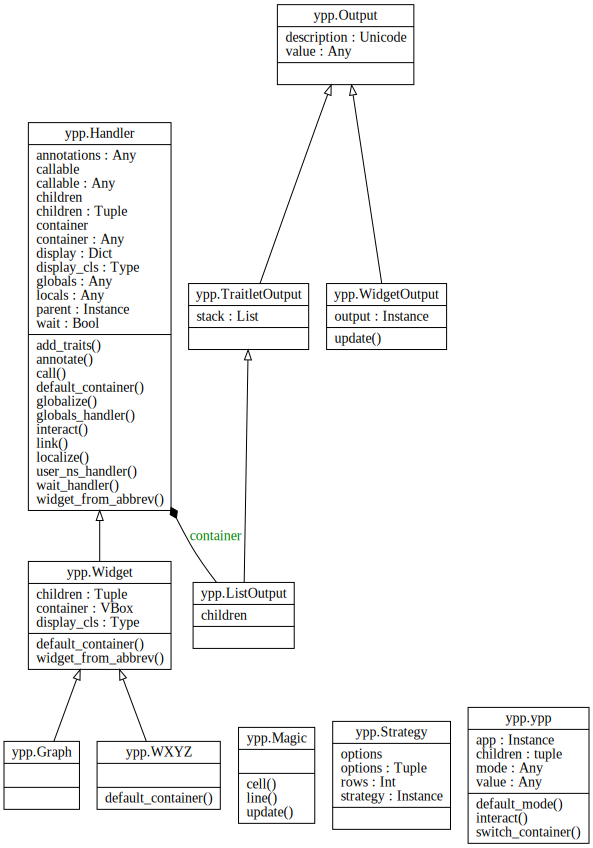

ypp.py:16: 'itertools' imported but unused
ypp.py:34: 'from jason import *' used; unable to detect undefined names
ypp.py:296: 'caller' may be undefined, or defined from star imports: jason
ypp.py:447: 'strategy' may be undefined, or defined from star imports: jason


In [18]:
    if __name__ == '__main__':
        import pidgin, nbconvert, black
        display = IPython.display.display
        with open('ypp.py', 'w') as f:
            f.write(black.format_str(nbconvert.PythonExporter(config={
                'TemplateExporter': {'exclude_input_prompt': True}
            }, preprocessors=[pidgin.publishing.TanglePreProcessor()]).from_filename('ypp.md.ipynb')[0], mode=black.FileMode()))
            if 0:
                with IPython.utils.capture.capture_output(stderr=False, stdout=False):
                    !pyreverse --show-builtin  --module-names=y -osvg  -b ypp 
            display(IPython.display.SVG('classes.svg'))
            with IPython.utils.capture.capture_output():
                !isort ypp.py
        if 10:
            !pyflakes ypp.py